In [1]:
# Import libraries
import zipfile
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline
from wordcloud import WordCloud
import seaborn as sns
from kaggle.api.kaggle_api_extended import KaggleApi

In [2]:
# Set Kaggle API credentials
api = KaggleApi()
api.authenticate()

In [3]:
owner = 'saloni1712'
dataset_name = 'threads-an-instagram-app-reviews'
# Download the dataset
api.dataset_download_files(f'{owner}/{dataset_name}')

In [6]:
# Open and extract the ZIP file
with zipfile.ZipFile('threads-an-instagram-app-reviews.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')

In [10]:
# Specify the path to a CSV file
csv_file_path = 'data/threads_reviews.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

In [11]:
df

,source,review_description,rating,review_date
0,Google Play,Meh. Not the greatest experience on a Chromebo...,2,2023-07-08 14:18:24
1,Google Play,Pretty good for a first launch!! Its easy to u...,3,2023-07-19 20:52:48
2,Google Play,"For a brand new app, it's very well optimized....",3,2023-07-06 23:03:11
3,Google Play,"Great app with a lot of potential! However, th...",3,2023-07-10 00:53:25
4,Google Play,"The app is good, but it needs a lot of functio...",3,2023-07-06 16:57:43
...,...,...,...,...
32905,App Store,This killed my dog. Mark zuckerburg strangled ...,1,2023-07-06 01:23:55
32906,App Store,Add Search and hashtag like Twitter !,1,2023-07-19 08:01:06
32907,App Store,bad twister,1,2023-07-17 06:39:13
32908,App Store,Yet another trash from Meta.,1,2023-07-07 17:47:16


In [12]:
# Randomly select 15 thousand rows to reduce the computational costs
df = df.sample(n=15000, random_state=42)

In [5]:
original_df = df.copy()

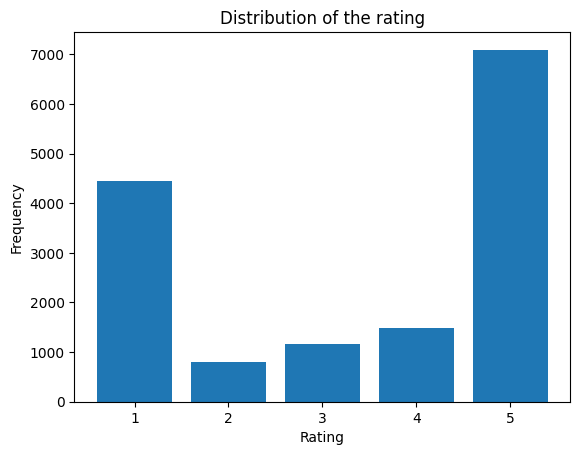

In [6]:
# Plot the distribution of the rating
plt.bar(['1', '2', '3', '4', '5'], df['rating'].value_counts().sort_index())
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of the rating')
plt.show()

From the bar chart it is apparent that there are more reviews with high ratings than with low ratings. Not only there are more positive reviews, but also many reviews have the highest score of evaluation equal to 5 stars. Moreover, it is evident that the dataset is unbalanced.

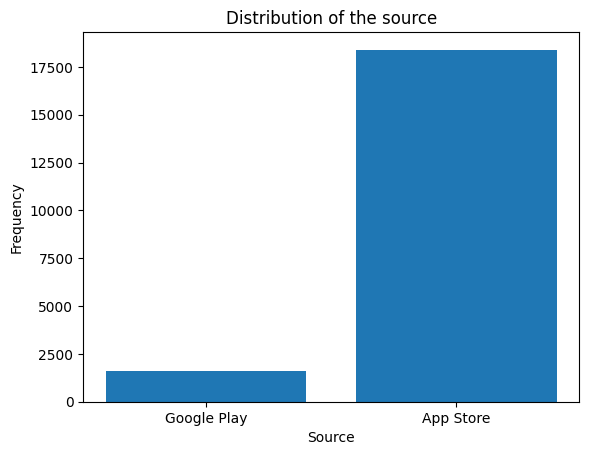

In [ ]:
# Plot the distribution of the source
plt.bar(['Google Play', 'App Store'], df['source'].value_counts().sort_index())
plt.xlabel('Source')
plt.ylabel('Frequency')
plt.title('Distribution of the source')
plt.show()

From the bar chart it is apparent that most of the reviews are coming from the App store.

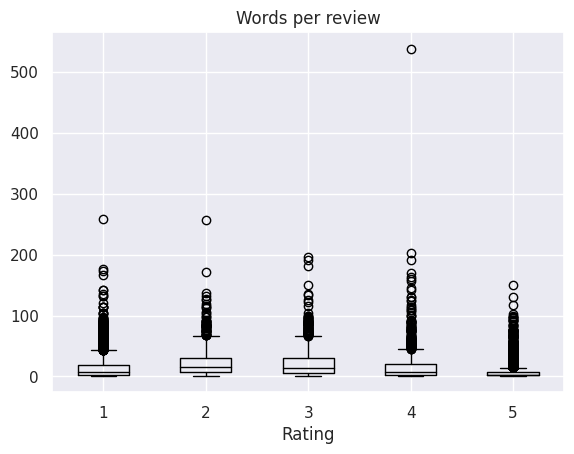

In [45]:
df["Words_per_review"] = df["review_description"].str.split().apply(len)
df.boxplot("Words_per_review", by="rating",
           color="black")
plt.suptitle("")
plt.xlabel("Rating")
plt.title('Words per review')
plt.show()

From the box plot it is apparent that most of the reviews are shorter than DistilBERT's maximum context size, which means that only a few might need to be truncated. Moreover, there are many outliers in the dataset.

In [13]:
# Recode ratings
target_map = { 1 : 0, 2 : 1, 3 : 2, 4 : 3, 5 : 4}
df['rating'] = df['rating'].map(target_map)

In [14]:
# Keep required columns only
df = df[['review_description','rating']]
# Rename columns
df.columns = ['text','labels']
# Save the file
df.to_csv('data.csv', index = False)

In [16]:
df = load_dataset('csv', data_files = 'data.csv')

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 76.79it/s]
Generating train split: 15000 examples [00:00, 195863.11 examples/s]


In [17]:
# Split data into test and train
df = df['train'].train_test_split(test_size=0.2, seed=42)

In [18]:
df

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 3000
    })
})

In [19]:
# Check whether the distributions of training and test sets are similar
pd.Series(df['test']['labels']).value_counts() / len(pd.Series(df['test']['labels'])) * 100

4    46.933333
0    28.666667
3    10.433333
2     7.933333
1     6.033333
Name: count, dtype: float64

In [20]:
pd.Series(df['train']['labels']).value_counts() / len(pd.Series(df['train']['labels'])) * 100

4    47.366667
0    29.875000
3     9.766667
2     7.766667
1     5.225000
Name: count, dtype: float64

# DistilBERT - classification of ratings

In [ ]:
# Create a tokenizer object
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [13]:
def tokenize(batch):
  return tokenizer(batch['text'], truncation = True)

In [ ]:
# Tokenize the dataset
tokenized_df = df.map(tokenize, batched = True)

In [ ]:
# Load a model
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = 5).to(device))

In [16]:
# Define the training parameters
training_args = TrainingArguments(output_dir='training_dir',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=2,
                                  weight_decay=0.01,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64
#                                   )

In [17]:
# Define evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [18]:
# Train the model
trainer = Trainer(model,
                  training_args,
                  train_dataset = tokenized_df["train"],
                  eval_dataset = tokenized_df["test"],
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics)
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.935300,0.869800,0.694333,0.633720
2,0.724100,0.879057,0.691667,0.652119


TrainOutput(global_step=1500, training_loss=0.8218087972005208, metrics={'train_runtime': 12733.6477, 'train_samples_per_second': 1.885, 'train_steps_per_second': 0.118, 'total_flos': 485796358764960.0, 'train_loss': 0.8218087972005208, 'epoch': 2.0})

In [19]:
# Calculate predictions
preds_output = trainer.predict(tokenized_df["test"])

In [20]:
# Compute metrics
preds_output.metrics

{'test_loss': 0.8790567517280579,
 'test_accuracy': 0.6916666666666667,
 'test_f1': 0.6521194613028879,
 'test_runtime': 578.4925,
 'test_samples_per_second': 5.186,
 'test_steps_per_second': 0.081}

From the result it is apparent that the accuracy is not very high. To check which categories get missclasified, the confusion matrix is calculated.

In [21]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [58]:
# Define a function to plot a confusion matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [23]:
y_valid = np.array(tokenized_df["test"]["labels"])

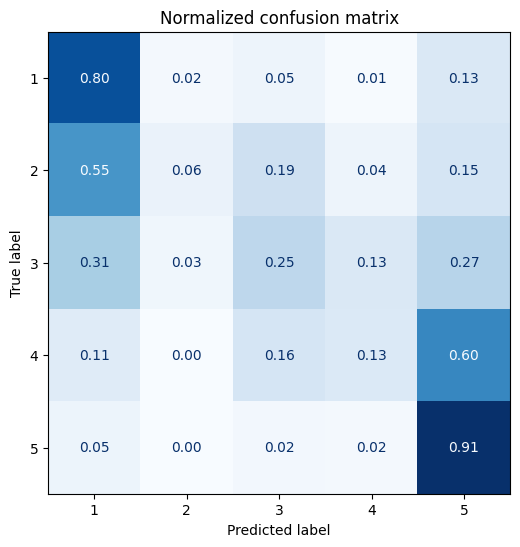

In [24]:
plot_confusion_matrix(y_preds, y_valid, ['1', '2', '3', '4', '5'])

From the confusion matrix it is evident that most errors occur because 2-star reviews are mistaken for 1-star reviews and 4-star reviews are wrongly labeled as 5-star reviews. One way to address this issue is to transform the 5-star rating system into three categories: positive, neutral and negative reviews. This way 1-star and 2-star reviews would be classified as negative reviews and 4-star and 5-star reviews would be labeled as positive reviews. Such transformation might lead to higher accuracy because the contrasts between the categories might be more distinct.

# Classification into positive and negative reviews

In [49]:
df = original_df.copy()

In [50]:
# Remove neutral reviews because they account for a small proportion of the reviews
df = df[df['rating'] != 3]

In [51]:
# Recode ratings into positive and negative reviews
target_map = { 1 : 0, 2 : 0, 4 : 1, 5 : 1}
df['rating'] = df['rating'].map(target_map)

In [52]:
# Keep required columns only
df = df[['review_description','rating']]
# Rename columns
df.columns = ['text','labels']
# Save the file
df.to_csv('data_two_classes.csv', index = False)

Built-in sentiment analysis pipeline

In [53]:
# Create a pipeline for sentiment analysis
classification_pip = pipeline('sentiment-analysis')
# Extract texts
texts = df['text'].to_list()
# Truncate texts
texts = [text[:512] for text in texts]
# Calculate predictions
predictions = classification_pip(texts)
# Change the form of the predictions by assigning 1 to positive class and 0 to negative class
preds = [1 if d['label'].startswith('P') else 0 for d in predictions]
preds = np.array(preds)
print("Accuracy:", accuracy_score(df['labels'], preds))
print("F1-score:", f1_score(df['labels'], preds, average="weighted"))

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Accuracy: 0.7767172812725958
F1-score: 0.7799331470956048


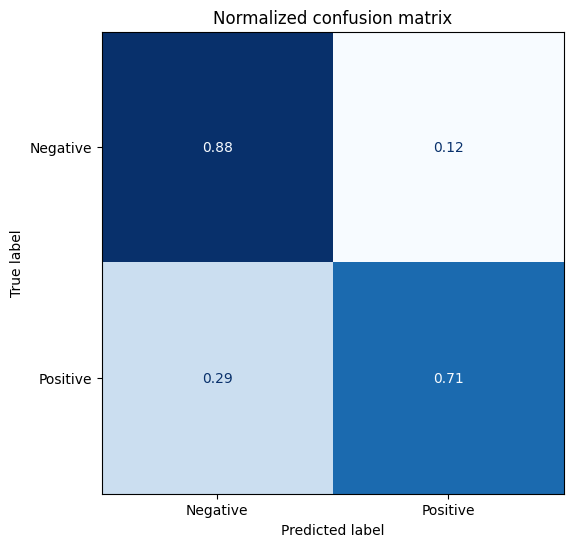

In [61]:
plot_confusion_matrix(preds, df['labels'], ['Negative', 'Positive'])

Based on the results, it is apparent that the classification into negative and positive classes yielded higher accuracy even without the need for fine-tuning.

# Fine-tuning DistilBERT

In [ ]:
df = load_dataset('csv', data_files = 'data_two_classes.csv')

In [10]:
# Split data into test and train
df = df['train'].train_test_split(test_size=0.2, seed=42)

In [11]:
df

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 11064
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 2766
    })
})

In [12]:
# Check whether the distributions of training and test sets are similar
pd.Series(df['test']['labels']).value_counts() / len(pd.Series(df['test']['labels'])) * 100

1    60.592914
0    39.407086
dtype: float64

In [13]:
pd.Series(df['train']['labels']).value_counts() / len(pd.Series(df['train']['labels'])) * 100

1    62.373463
0    37.626537
dtype: float64

In [14]:
# Create a tokenizer object
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
# Tokenize the dataset
tokenized_df = df.map(tokenize, batched = True)

In [20]:
# Load a model
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = 2).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Define the training parameters
training_args = TrainingArguments(output_dir='training_dir',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=2,
                                  weight_decay=0.01,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64
                                  )

In [22]:
# Train the model
trainer = Trainer(model,
                  training_args,
                  train_dataset = tokenized_df["train"],
                  eval_dataset = tokenized_df["test"],
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics)
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.347600,0.293049,0.892986,0.892899
2,0.252500,0.324933,0.894071,0.893849


TrainOutput(global_step=1384, training_loss=0.27624689774706185, metrics={'train_runtime': 11106.5978, 'train_samples_per_second': 1.992, 'train_steps_per_second': 0.125, 'total_flos': 420058260744384.0, 'train_loss': 0.27624689774706185, 'epoch': 2.0})

In [23]:
# Calculate predictions
preds_output = trainer.predict(tokenized_df["test"])

In [24]:
# Compute metrics
preds_output.metrics

{'test_loss': 0.32493260502815247,
 'test_accuracy': 0.8940708604483008,
 'test_f1': 0.8938485200760882,
 'test_runtime': 566.9498,
 'test_samples_per_second': 4.879,
 'test_steps_per_second': 0.078}

In [25]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [26]:
y_valid = np.array(tokenized_df["test"]["labels"])

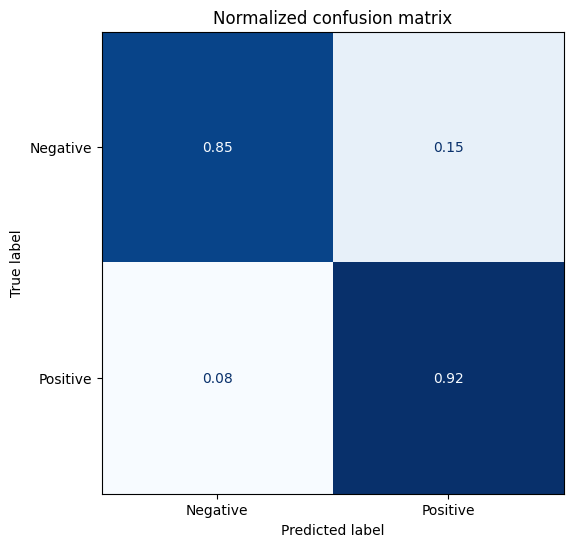

In [27]:
# Plot a confusion matrix
plot_confusion_matrix(y_preds, y_valid, ['Negative', 'Positive'])

The results clearly indicate that fine-tuning contributed to an increase in both accuracy and F1-score. Additionally, the proportion of misclassifications decreased significantly compared to the initial classification based on ratings.

# Word cloud

(-0.5, 1999.5, 1199.5, -0.5)

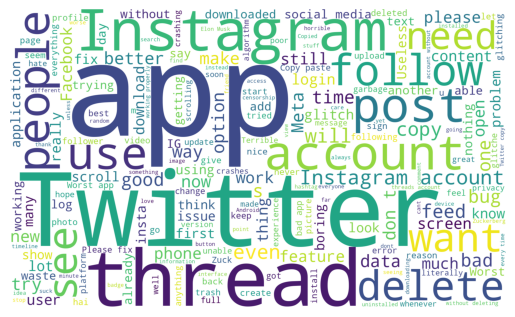

In [69]:
df = pd.read_csv('data_two_classes.csv')
# Create a word cloud
all_text = ' '.join(df['text'].loc[df['labels'] == 0])
word_cloud = WordCloud(width=2000, height=1200, background_color='white').generate(all_text)
sns.set_theme(style = 'white', palette = 'pastel')
plt.imshow(word_cloud)
plt.axis('off')

The word cloud reveals that reasons for negative reviews encompass issues such as app glitches, app crashes, and dissatisfaction with the content. For a more comprehensive insight into these concerns, we can filter rows where mentions of glitches, crashes and content occur.

In [71]:
pd.set_option('display.max_colwidth', None)

In [72]:
df[(df['text'].str.contains('glitches', case=False)) & (df['labels'] == 0)]

,text,labels
249,They really need to fix the glitches and bugs on Instagram first before launching clone apps.,0
268,"Full of glitches While scrolling full of Shaking screen,draging🥴 Fix it up , I already install the app👍 because of that glitches 😕 it is so irritating",0
651,I couldn't even see my timeline it glitches like hell but I like the idea,0
1171,had worst experience......Like tooooo manyyyyy glitches... posting here after tooooooo many attempts,0
1353,In app havein app how make glitches now,0
...,...,...
13093,There are glitches. Help.,0
13199,"My app glitches when I scroll, until I minimize then return to app. 😠",0
13388,I am using a device on Android 9 and the app is not functioning properly it glitches and the surfaces overlaps with eachother like its hacked or smn. Please look into it (update : it only happens in dark mode),0
13445,Not a bad app it needs an update becoz whenever I upload video there is audio problem...automatically becomes muted ...u can also can't see live videos on threads ..only notification of live video is coming... Most important is there is login glitch... whenever I switched my accounts on instagram app ..the threads app also log out my account on threads app.. Every time I have to login my accounts on both apps..plz fix these glitches ..thanku,0


In [73]:
df[(df['text'].str.contains('crashes', case=False)) & (df['labels'] == 0)]

,text,labels
124,"Frequent crashes,",0
137,App crashes whenever I try to upload a picture. Tried reinstalling and it did not work. App is installed on Samsung S23 Ultra.,0
164,"The app crashes too much, the screen appears unclear and irresponsive.",0
173,Crashes a lot,0
636,"App keeps crashing. If i scroll for a while or while writing a thread, it crashes. If i am responding to a thread which has a vertical photo/video, i cannot see what i am typing. It seems as if interns have made this app.",0
...,...,...
12945,The app crashes whenever I open it,0
13232,The app crashes everytime I upload a media.,0
13549,Great concept but continually crashes when I try to type or @ anyone,0
13751,"When publishing a post with iphone se3, the app crashes",0


In [74]:
df[(df['text'].str.contains('content', case=False)) & (df['labels'] == 0)]

,text,labels
28,The fact that it forces me to see content I don't want gives it a one-star review immediately. I don't want to see any content from anyone other than the followers I have selected.,0
102,"First, they are accessing precise location without consent. The app is such a twitter knock off that it is hard to use you and even harder to navigate for content you want. The amount of personal data they are taking without even a single option to reject or approve is ridiculous. Will not be using this unethical app.",0
285,"After reading “Data Linked to You” I couldn’t think of a metric they’re not collecting. Someone needs to tell Meta that “1984” was a warning and not an instruction manual.\n\nIf you loved the abuse Meta foisted of you with Facebook and Instagram through the pushing of the most inflammatory content solely to raise engagement and their emotionally manipulative advertising all the while tracking you like a parolee with a GPS ankle bracelet you’ll love Treads. Otherwise join Mastodon which doesn’t manipulate your feed, has no advertising and collects zero tracking data on its users.\n\nThreads again shows Meta is an electronic version of cancer.",0
293,I got to enjoy the app for maybe 2 hours before it decided that it was going to crash whenever I try to reply to a thread or post my own. I can However still follow people and like post no problem. I can also respond to follow requests. But I can't use the app to share my own content which is the whole reason I downloaded it. I have seen some reviews about it doing the same thing for anyone with an Iphone 8 or lower and guess what? I have an aiphone 8. Please fix this I want to enjoy the app fully.,0
389,"Content moderation seems to be just as lacking as FB, which is not a surprise as it’s being run by Meta.",0
...,...,...
13755,"I’ve been hoping for something to replace Twitter and Facebook for awhile now (since Twitter was ruined and Facebook has been less and less personal for years) — so naturally Threads intrigued me. So far I’m cautiously optimistic, but it does bother me that it’s owned by Facebook/Instagram and the app is very minimal at the start. So we’ll see how it goes.\n\nMy wife and I both downloaded Threads within 24 hours of each other. I’ve had a positive experience with it so far, but for some reason her account showed her some very questionable stuff (three posts in around thirty seconds of scrolling). I’m guessing this is because I follow more accounts so I don’t see posts from unfollowed accounts, but it could also be due to Instagram privacy/security settings since many of those sync over.\n\nMy main concern at this point is with content visibility control. When someone I follow replies to someone I don’t, I should see a button to show the original post and not the full post by default. There should not be random posts on the feed, especially when they highlight risqué photos. Some people may like seeing unrelated posts, but there needs to be a simple control for seeing this or not. As it stands, my wife has deactivated her account already (less than ten minutes of use) and I may be following suit rather shortly. I understand it’s very new still, but this is important and needs to be addressed promptly for the sake of users and the platform.",0
13768,Trash. This is a waste of time yall. They keep distracting us with bs instead of dealing with real life. Why do i need to see how everbody feels especially when u wont allow me to see content from people i follow unless i tap on each of their page. Why would i be interested in peoples content that i do not follow. Its like there forcing you to engage virtually and not go outside stay woke,0
13786,Worst app tbh as soon as I opened the app all the content was overlapping each other I couldn't even use it.. I installed it again but still the same,0
13798,"Can only search for users not post content. With Twitter I can search for say ""protest London"" and see all tweets about protests in London. N

From filtered texts it is evident that some people give negative reviews due to glitches and crashes in the system when uploading photos, scrolling the feed and typing. Moreover, users are not satisfied with the content as they are shown suggested posts instead of only the posts of the people that they are following.

(-0.5, 1999.5, 1199.5, -0.5)

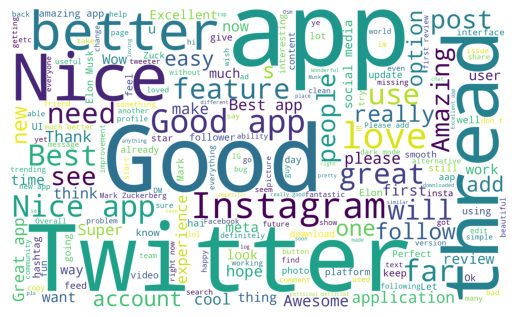

In [75]:
# Create a word cloud
all_text = ' '.join(df['text'].loc[df['labels'] == 1])
word_cloud = WordCloud(width=2000, height=1200, background_color='white').generate(all_text)
sns.set_theme(style = 'white', palette = 'pastel')
plt.imshow(word_cloud)
plt.axis('off')

In [85]:
df[(df['text'].str.contains('feature', case=False)) & (df['labels'] == 1)]

,text,labels
55,"This app is very cool nd its features is very easy to use nd name is osm(Threads). Now we will replying to anyone "" Main Use Threads Kr dunga""",1
105,"Good app but few features lack like automated bot, ai bots and also hastags there should be an extra tab for discover. Thanks btw.",1
226,Include Message features,1
329,This is the best app I had ever used. Its logo is very attractive. Its has autocorrect feature also that is very helpful. So guy's What's the delay Download threads now and follow my threads account : parkour_community_1,1
351,must add some switch accounts features so its getting good.,1
...,...,...
13431,"Hey meta I'm I will give this app to 5 stars but in this app so many features are missing like trending feed , following people's posts,#,DM and many more please improve the app and user experience",1
13436,"I like this application ❤️💥💯, Fantastic features. Twitter wali feeling, Instagram wali audience 👏🏻",1
13505,"Nice 👍 , But need but some features are missing... like DM, place to find liked posts... can't add hashtags as well. Hopefully in the coming days, we will see the features added and some more added features.",1
13617,"This app is honestly pretty great so far but it’s just missing some key features! (Following tab, Dms, viewing your likes, a trending or explore page, hashtags etc. It really feels like a peaceful and fun app to use please don’t change the feel of it, otherwise people are gonna drop off and not come back.",1


In [84]:
df[(df['text'].str.contains('social media', case=False)) & (df['labels'] == 1)]

,text,labels
321,"Seems like a good Twitter replacement. but as a person whose main use of social media is following sports, it really needs the chronological timeline",1
535,"This is an Amazing app! I like how it performs, it's buttery-smooth and so fast, I wish they add couple of features to the future updates such as a following page, being able to edit Threads and DMs would be great. But overall it's a great social media app and I'm enjoying it right now.",1
808,Best option for sharing knowledge with public on social media.,1
898,Best Social media Ever All thanks to mark Zuckerberg ♥️🙏🏿,1
963,Nyc social media app,1
...,...,...
13234,"Honestly, one of the smoothest launches of a new social media ever? Really impressed so far. The brilliance is in the simplicity and easy community building.",1
13279,So nice play this aap on social media,1
13479,"Need more like downloading pics, dark mode, sharing post with other social media.",1
13587,"Don't like social media, never had a Twitter account, but I like the idea of Twitter going bust due to all the bad choices by Elon Musk, so downloading this and signing up to help out boost it's numbers",1


In [77]:
df[(df['text'].str.contains('interface', case=False)) & (df['labels'] == 1)]

,text,labels
71,Good interface.🥰,1
77,Cool black interface,1
261,"Love the interface, but can't get audio to work on videos using Android.",1
413,"Smart, convenient, easy user interface but need some changes as it could look different and may print unique identity.",1
693,"Smooth user interface so far, looking forward to some improvements and new features",1
...,...,...
11704,Totally an outstanding app an easy interface and great to connect.,1
12193,"Downloaded yesterday and I’m enjoying it for what it is so far; sign-up was super easy since you can import all your data from Instagram, and I love how you can directly access other accounts’ Insta pages to follow them there too.\n\nMy only issue is that the app feels a little bare-bones as of now. I understand it’s brand new and will be in the process of developing itself over time, but I’d love to see a bit more in terms of interface. The app feels a bit empty without a proper tagging system and it’s extremely hard for me to find new content and users to follow because my feed is mostly people I already follow on Instagram (plus random verified accounts and one or two new creators I find interest in). Please consider implementing a hashtag or keyword function for the Search bar (or maybe even an Explore page), and I’d probably find a lot more interest in the app!\n\nOverall, this is a pretty decent start and I’m interested to see where it goes next… and to have a place to post my 3 AM intrusive thoughts.",1
12196,"Nice interface, Hope doesn't change your mind in interface in other update .🙂",1
13299,"More simple and easier experience than Twitter, it needs some features and will domenate this field, like private messaging, website for PC interface, trending hashtags and clear plan for marketers and analysts for digital marketing field.",1


From the positive reviews it is apparent that people are satisfied with the interface of the app as it is convenient and easy to use. However, many users mention some of the features that are missing such as hashtags and DMs.